# Team HATA – Research Data Pipeline Demo (INST326)

This notebook demonstrates our research data management system:

- **Researcher**: Workspace + CSV IO + ethics orchestration  
- **Dataset**: Cleaning, QA, schema enforcement, ethics checks, plotting  
- **Analysis**: Declarative data pipelines with provenance logs  
- **Experiments**: LabExperiment, FieldStudy, Survey, and ResearchProject composition  
- **Sample**: Lightweight sampling and summarization utilities  

We’ll walk through a realistic “dirty data” workflow:

1. Create and inspect a messy CSV
2. Clean and standardize it with `Dataset`
3. Run ethics and schema checks
4. Execute an `Analysis` pipeline
5. Attach data to experiments and project
6. Use `Sample` for focused inspection
7. Run the full test suite (unit + integration + system tests)


In [49]:
"""
CELL 1: Create a 'dirty' sample_data.csv for the demo.

This cell programmatically writes a small CSV file with:
- Inconsistent spacing and capitalization in column names and values
- Missing values
- Numeric values stored as strings
- PII fields (Name, Email) and a Consent column

We do this so the notebook is self-contained and always has the demo data.
"""

from pathlib import Path
import csv

sample_path = Path("sample_data.csv")

rows = [
    ["User", " Amount ", " City ", " pH ", " mass_mg", " temperature_c ", " Name ", " Email ", " Consent "],
    [1,  " 4 ",   ' "A " ',  7.1,  "12.5",  22.0,           "Alice",        "alice@example.com", "YES"],
    [1,  "-5",    ' "A"',    7.0,  "thirteen", 22.5,        " Bob ",        "bob@example.com",   "no"],
    [2,  '"3"',   ' "B " ',  6.8,  "15.2",   "",            "Carol",        "",                  "Yes"],
    [2,  "7",     ' " B"',   6.9,  "14.8",   23.1,          "  David  ",    "david@example.com", "NO"],
    [3,  '" "',   "C",       7.2,  "missing", 21.8,         "Eve",          "eve@example.com",   "yes"],
]

with sample_path.open("w", newline="", encoding="utf-8") as f:
    writer = csv.writer(f)
    writer.writerows(rows)

sample_path.resolve()


WindowsPath('C:/Users/heinl/OneDrive/Documents/UMD Information Science BS/INST326/TEAM PROJECT TEST!/INST326-TeamProject/src/sample_data.csv')

In [50]:
"""
CELL 2: Import project classes and libraries used in the demo.
"""

import pandas as pd

from researcher import Researcher
from dataset import Dataset
from analysis import Analysis
from experiment import (
    LabExperiment,
    FieldStudy,
    Survey,
    ResearchProject,
    render_overview,
)
from Sample import Sample


In [ ]:
"""
CELL 3: Load the dirty CSV into a Dataset using Researcher.

- Researcher handles workspace + CSV IO.
- Dataset wraps the DataFrame and exposes cleaning/QA utilities.
"""

# Use current directory as the workspace so paths stay simple
r = Researcher("Alice", workspace=".")

ds_raw = r.read_csv("sample_data.csv")
ds_raw.df.head()


,User,Amount,City,pH,mass_mg,temperature_c,Name,Email,Consent
0,1,4,"""A """,7.1,12.5,22.0,Alice,alice@example.com,YES
1,1,-5,"""A""",7.0,thirteen,22.5,Bob,bob@example.com,no
2,2,"""3""","""B """,6.8,15.2,NaN,Carol,NaN,Yes
3,2,7,""" B""",6.9,14.8,23.1,David,david@example.com,NO
4,3,""" """,C,7.2,missing,21.8,Eve,eve@example.com,yes


In [ ]:
"""
CELL 4: Run basic data quality checks on the raw dataset.

- detect_missing(): NA counts per column
- detect_duplicates(): duplicate rows (if any)
"""

print("Missing values per column:")
missing = ds_raw.detect_missing()
missing



Missing values per column:


User               0
 Amount            0
 City              0
 pH                0
 mass_mg           0
 temperature_c     1
 Name              0
 Email             1
 Consent           0
dtype: int64

In [ ]:
"""
CELL 5: Standardize column names and clean string columns.

- standardize_column_names(case="snake"): normalizes headers to snake_case.
- clean_strings([...]): strips whitespace, lowers, and collapses spaces for text cols.
"""

# Normalize headers like " Amount " -> "amount", " Name " -> "name"
ds_norm = ds_raw.standardize_column_names(case="snake")

# Clean selected string columns
text_cols = ["city", "name", "email", "consent"]
ds_clean = ds_norm.clean_strings(text_cols)

ds_clean.df.head()


,user,amount,city,ph,mass_mg,temperature_c,name,email,consent
0,1,4,"""a """,7.1,12.5,22.0,alice,alice@example.com,yes
1,1,-5,"""a""",7.0,thirteen,22.5,bob,bob@example.com,no
2,2,"""3""","""b """,6.8,15.2,NaN,carol,NaN,yes
3,2,7,""" b""",6.9,14.8,23.1,david,david@example.com,no
4,3,""" """,c,7.2,missing,21.8,eve,eve@example.com,yes


In [ ]:
"""
CELL 6: Run a basic research ethics check.

- We treat name and email as PII.
- consent column should be truthy for rows with PII.
- Researcher.ethics_report(...) delegates to Dataset.validate_research_ethics_compliance().
"""

ethics = r.ethics_report(
    ds_clean,
    pii_cols=["name", "email"],
    consent_col="consent",
)
ethics


{'compliant': False,
 'issues': ["2 row(s) with PII in 'name' without consent",
  "2 row(s) with PII in 'email' without consent"]}

In [ ]:
"""
CELL 7: Enforce a simple schema over the cleaned dataset.

We:
- Coerce types (int, float, bool/string) for key columns.
- Track coercions, invalid nulls, and invalid values.

This uses Dataset.enforce_schema(), which returns:
    (enforced_dataset, report_dict)
"""

schema = {
    "user": {"dtype": "int", "nullable": False},
    "amount": {"dtype": "float", "nullable": True},
    "ph": {"dtype": "float", "nullable": True},
    "mass_mg": {"dtype": "float", "nullable": True},
    "temperature_c": {"dtype": "float", "nullable": True},
    "consent": {
        "dtype": "string",
        "nullable": True,
        "allowed": ["yes", "no"],  # after cleaning, values are lowercased
    },
}

ds_enforced, schema_report = ds_clean.enforce_schema(schema)
schema_report

ds_enforced.df.head()


,user,amount,city,ph,mass_mg,temperature_c,name,email,consent
0,1,4.0,"""a """,7.1,12.5,22.0,alice,alice@example.com,yes
1,1,-5.0,"""a""",7.0,<NA>,22.5,bob,bob@example.com,no
2,2,<NA>,"""b """,6.8,15.2,<NA>,carol,NaN,yes
3,2,7.0,""" b""",6.9,14.8,23.1,david,david@example.com,no
4,3,<NA>,c,7.2,<NA>,21.8,eve,eve@example.com,yes


In [ ]:
"""
CELL 8: Run an Analysis pipeline end-to-end.

Steps:
1. Filter out negative amounts.
2. Group by user and sum the amount.
3. Sort users by total amount descending.

This uses the Analysis class and its run_pipeline(dataset) method.
"""

pipe = Analysis(
    name="demo_pipeline",
    steps=[
        {"op": "filter", "expr": "amount >= 0"},
        {"op": "groupby_agg", "by": ["user"], "metrics": {"amount": "sum"}},
        {"op": "sort", "by": ["amount"], "ascending": False},
    ],
)

final_ds, runlog = pipe.run_pipeline(ds_enforced)

final_ds.df


,user,amount
1,2,7.0
0,1,4.0


In [ ]:
"""
CELL 9: Inspect the pipeline provenance log.

Each log entry contains:
- step index
- op name
- rows_before / rows_after
- cols_before / cols_after
- human-readable note
"""

pd.DataFrame(runlog)


,step,op,rows_before,rows_after,cols_before,cols_after,note
0,1,filter,5,2,"[user, amount, city, ph, mass_mg, temperature_...","[user, amount, city, ph, mass_mg, temperature_...",filter expr='amount >= 0'
1,2,groupby_agg,2,2,"[user, amount, city, ph, mass_mg, temperature_...","[user, amount]",groupby_agg by=['user']
2,3,sort,2,2,"[user, amount]","[user, amount]",sort by=['amount']


In [ ]:
"""
CELL 10: Demonstrate experiments and project-level composition.

- Create LabExperiment, FieldStudy, Survey.
- Attach dataset to lab and process it.
- Build a ResearchProject that "has many" experiments.
- Call summary() and render_overview() to show polymorphism.
"""

# Lab experiment attached to enforced dataset
lab = LabExperiment("L1", "Lab Demo Experiment", biosafety_level=2)
lab.attach_dataset(ds_enforced.df, name="lab_input")
lab_processed = lab.process_dataset(ds_enforced)

# Additional experiment types
field = FieldStudy("F1", "Field Study Demo", region="MD")
survey = Survey("S1", "Survey Demo", consent_col="consent")

# Project composition
project = ResearchProject("P1", "Integrated Study Demo")
project.add_experiment(lab)
project.add_experiment(field)
project.add_experiment(survey)

print(project.summary())
print()
print(render_overview(project.experiments))


ResearchProject P1 - Integrated Study Demo
Experiments (3):
- LabExperiment L1: Lab Demo Experiment
- FieldStudy F1: Field Study Demo
- Survey S1: Survey Demo

LabExperiment(L1) • Lab Demo Experiment • policy=Lab-restricted access (BSL-2); only approved lab personnel may access raw data.
FieldStudy(F1) • Field Study Demo • policy=Data access governed by field conditions and partner agreements; region=MD.
Survey(S1) • Survey Demo • policy=Responses stored with anonymous identifiers; raw data restricted to IRB-approved team.


In [ ]:
"""
CELL 11: Use Sample for focused inspection.

Purpose:
- Create a Sample from the enforced dataset.
- Keep only rows with non-negative amounts.
- Restrict to a few relevant columns.
- Summarize numeric and categorical columns via Sample.summarize().
"""

# Ensure the mask is a plain boolean Series so Sample.from_dataset is happy
sample = Sample.from_dataset(
    ds_enforced,
    rows=lambda df: (df["amount"] >= 0).fillna(False).astype(bool),
    cols=["user", "amount", "city", "consent"],
    name="non_negative_amounts",
)

print(sample)
sample.data.head()


Sample(name=non_negative_amounts, shape=(2, 4))


,user,amount,city,consent
0,1,4.0,"""a """,yes
3,2,7.0,""" b""",no


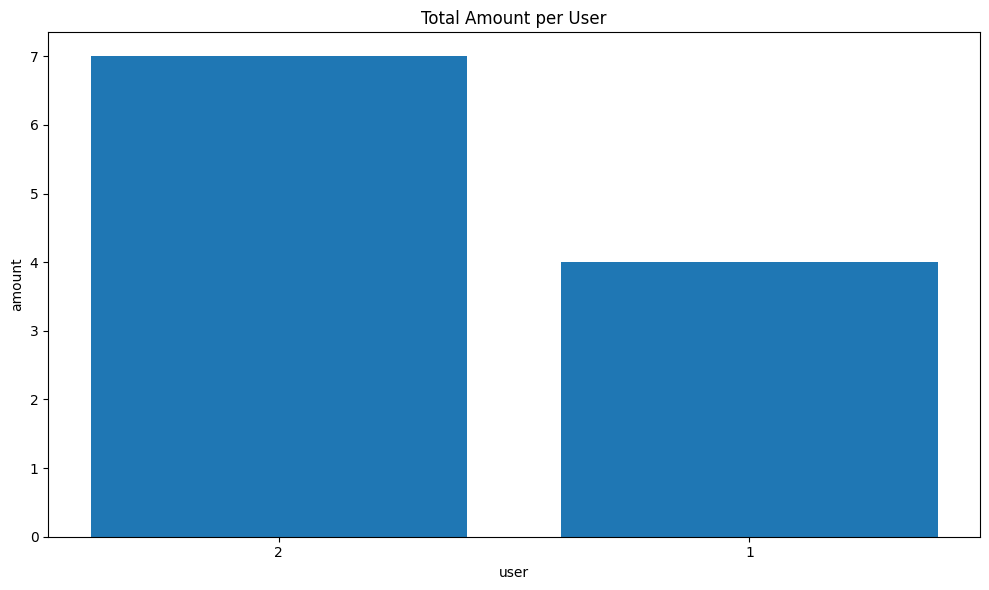

In [ ]:
"""
CELL 12: Basic bar chart of total amount per user.

Uses Analysis.plot_bar(), which delegates to Dataset.generate_data_report().
"""

fig = pipe.plot_bar(final_ds, x="user", y="amount", title="Total Amount per User")
fig


In [48]:
"""
CELL 13: Run the full unittest suite for our project.

Tests include:
- Dataset, Researcher, Sample, Analysis
- Experiments and ResearchProject
- End-to-end workflow (system test)

See classification docstring in test_inst326_hata.py for details.
"""

import unittest
import matplotlib
matplotlib.use("Agg")  # avoid popping plots in the notebook

suite = unittest.defaultTestLoader.loadTestsFromName("test_inst326_hata")
runner = unittest.TextTestRunner(verbosity=1)
runner.run(suite)


............................
----------------------------------------------------------------------
Ran 28 tests in 0.106s

OK


<unittest.runner.TextTestResult run=28 errors=0 failures=0>